In [1]:
from aiida import load_profile, orm
from aiida_worktree import node, WorkTree, build_node

load_profile()

Profile<uuid='5ca88b1d2d41436bb1747cc5c08179db' name='default'>

# Experiment: convergence of PW total energy with respect to cutoff

The idea is to create 
- simple worktree that is generated dynamically with respect to a given set of inputs on which to run (for example, the list of ecuts)
- a final node which checks if it is converged or not
- then, a workchain to restart with hints in case no convergence (simple, like input list + 10 Ry)

In [2]:
import json

In [3]:
with open("h2o.json","r") as file:
    d = json.load(file)

In [4]:
d

{'workflow': {'functional': 'ki',
  'method': 'dfpt',
  'init_orbitals': 'kohn-sham',
  'from_scratch': True,
  'alpha_numsteps': 1,
  'mt_correction': True,
  'pseudo_library': 'sg15'},
 'atoms': {'cell_parameters': {'vectors': [[9.5142, 0.0, 0.0],
    [0.0, 8.0, 0.0],
    [0.0, 0.0, 8.5861]],
   'units': 'angstrom',
   'periodic': False},
  'atomic_positions': {'units': 'angstrom',
   'positions': [['O', 6.7571, 6.0, 5.9023166667],
    ['H', 7.5142, 6.0, 6.4884166667],
    ['H', 6.0, 6.0, 6.4884166667]]}},
 'calculator_parameters': {'ecutwfc': 45.0, 'ecutrho': 180.0, 'nbnd': 8}}

In [5]:
ndata = {"path": "aiida_quantumespresso.workflows.pw.base.PwBaseWorkChain"}
pw_baseWchain = build_node(ndata)

In [6]:
pw_node = pw_baseWchain()
print("Inputs:")
for input in pw_node.inputs:
    if "." not in input.name:
        print(f"  - {input.name}")
print("Outputs:")
for output in pw_node.outputs:
    if "." not in output.name:
        print(f"  - {output.name}")

Inputs:
  - metadata
  - max_iterations
  - clean_workdir
  - handler_overrides
  - pw
  - kpoints
  - kpoints_distance
  - kpoints_force_parity
Outputs:
  - remote_folder
  - remote_stash
  - retrieved
  - output_parameters
  - output_structure
  - output_trajectory
  - output_band
  - output_kpoints
  - output_atomic_occupations


In [7]:
for_ase = {
    "numbers":None,
    "pbc": [False,False,False],
    "positions":d["atoms"]["atomic_positions"]["positions"],
    "cell":d["atoms"]["cell_parameters"]["vectors"]
}

atoms = ""
positions = []
for i in for_ase["positions"]:
    atoms += i[0]
    positions.append(i[1:])


In [8]:
from ase import Atoms
import copy

H2O = Atoms(atoms,
    positions=positions,
    cell=d["atoms"]["cell_parameters"]["vectors"],
    pbc=[0, 0, 0])


In [26]:


structure = orm.StructureData(ase=H2O)

pw_code = orm.load_code("pw-7.2@localhost")
kcw_code = orm.load_code("kcw-7.2@localhost")
pseudo_family = orm.load_group("sg15_v1.2/pbe/SR")
pseudos_ = pseudo_family.get_pseudos(structure=structure) 
valence = 1+1+6

scf_params = {
 'SYSTEM': {'nosym': False,
  'occupations': 'fixed',
  'nbnd': d["calculator_parameters"]["nbnd"],
  'tot_magnetization': 0,
  'nspin': 2,
  'starting_magnetization(1)': 0.0,
  'ecutwfc': d["calculator_parameters"]["ecutwfc"],
  'ecutrho': d["calculator_parameters"]["ecutrho"]},
}

if not d["atoms"]['cell_parameters'].get("periodic", True): scf_params["SYSTEM"]['assume_isolated'] = "mt"

metadata = {
    'options': {
        'max_wallclock_seconds': 3600,
        'resources': {
            "num_machines": 1,
            "num_mpiprocs_per_machine": 2,
            "num_cores_per_mpiproc": 1,
        },
        'custom_scheduler_commands': u"export OMP_NUM_THREADS="+str(1),
    }
}

In [134]:
ecut_list = range(10,100,10) # Ry

In [135]:
wt = WorkTree("scf_ecut_H2O")
# SCF nodes:
# Output result from context
@node.group(outputs=[["ctx.result", "result"]]) # what is save in ctx.result, will be the output node "result"
def all_scf(pw_code,structure,scf_params,ecut_list,pseudos_,metadata):
    wt = WorkTree("run_loop_scf")
    for ecut in ecut_list:
        updated_params = copy.deepcopy(scf_params)
        updated_params["SYSTEM"]["ecutwfc"] = ecut
        scf = wt.nodes.new(pw_baseWchain, name=f"scf_{ecut}")
        scf.set_from_protocol(
            code = pw_code,
            structure = structure,
            overrides = {"pw":{"parameters":updated_params}}
        )
        scf.inputs["pw"].value["metadata"]=metadata
        scf.inputs["pw"].value["metadata"]=metadata
        scf.inputs["pw"].value["pseudos"]=pseudos_
        scf.to_ctx = [["output_parameters", f"result.tot_E.scf_{ecut}"]]

    return wt


all_scf_node = wt.nodes.new(all_scf, name="all_scf_node")
all_scf_node.set(
    {
        "pw_code":pw_code,
        "structure":structure,
        "scf_params":scf_params,
        "ecut_list":ecut_list,
        "pseudos_":pseudos_,
        "metadata":metadata,
        }
    )

"""
# define sum node
@node.calcfunction()
def store_list_ecut_and_energies(**out_d):
    total = []

    for name,data in out_d[tot_E].items():
        d = data.get_dict()["energy"]
        total.append(d)
    return orm.List(total)
    
try_ctx = wt.nodes.new(store_list_ecut_and_energies, name="try_ctx")
wt.links.new(all_scf_node.outputs["result"], try_ctx.inputs["out_d"]) # link SCF and KC conversion"""

'try_ctx = wt.nodes.new(store_list_ecut_and_energies, name="try_ctx")\nwt.links.new(all_scf_node.outputs["result"], try_ctx.inputs["out_d"]) # link SCF and KC conversion'

In [136]:
wt.submit(wait=True, timeout=300)

WorkTree node created, PK: 2088


In [137]:
!verdi process report 2088

2024-02-08 17:46:34 [685 | REPORT]: [2088|WorkTree|continue_worktree]: Continue worktree.
2024-02-08 17:46:34 [686 | REPORT]: [2088|WorkTree|continue_worktree]: nodes ready to run: all_scf_node
2024-02-08 17:46:34 [687 | REPORT]: [2088|WorkTree|run_nodes]: Run node: all_scf_node, type: worktree
2024-02-08 17:46:57 [688 | REPORT]:   [2134|WorkTree|continue_worktree]: Continue worktree.
2024-02-08 17:46:59 [689 | REPORT]:   [2134|WorkTree|continue_worktree]: nodes ready to run: scf_10,scf_20,scf_30,scf_40,scf_50,scf_60,scf_70,scf_80,scf_90
2024-02-08 17:46:59 [690 | REPORT]:   [2134|WorkTree|run_nodes]: Run node: scf_10, type: workchain
2024-02-08 17:47:00 [691 | REPORT]:   [2134|WorkTree|run_nodes]: Run node: scf_20, type: workchain
2024-02-08 17:47:00 [692 | REPORT]:   [2134|WorkTree|run_nodes]: Run node: scf_30, type: workchain
2024-02-08 17:47:01 [693 | REPORT]:   [2134|WorkTree|run_nodes]: Run node: scf_40, type: workchain
2024-02-08 17:47:02 [694 | REPORT]:   [2134|WorkTree|run_nod

In [138]:
wt.process.called[0].outputs.group_outputs.result.tot_E.scf_20.creator

<CalcJobNode: uuid: 875730a8-b38a-4932-b31b-bf60c171bda1 (pk: 2185) (aiida.calculations:quantumespresso.pw)>

In [139]:
ecut_res,tot_E_res = [],[]
results = wt.process.called[0].outputs.group_outputs.result.tot_E
for i,j in results.items():
    ecut_ = j.creator.inputs.parameters.get_dict()["SYSTEM"]["ecutwfc"]
    tot_energy_ = j.get_dict()["energy"]
    print(ecut_,tot_energy_)
    ecut_res.append(ecut_)
    tot_E_res.append(tot_energy_)

10 -414.74946874889
20 -442.10181451284
30 -456.49508517329
50 -465.8179349436
40 -463.26261569433
70 -466.89930892725
90 -466.94445329268
80 -466.94101839975
60 -466.67135481427


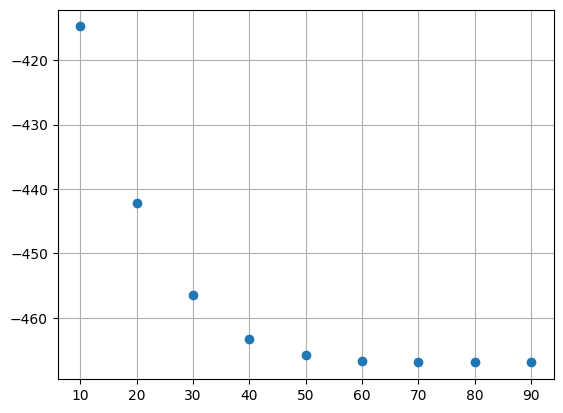

In [144]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(ecut_res,tot_E_res,'o')